<a href="https://colab.research.google.com/github/urv2450/IMS24254-DSC-212-Assignment/blob/main/IMS24254.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

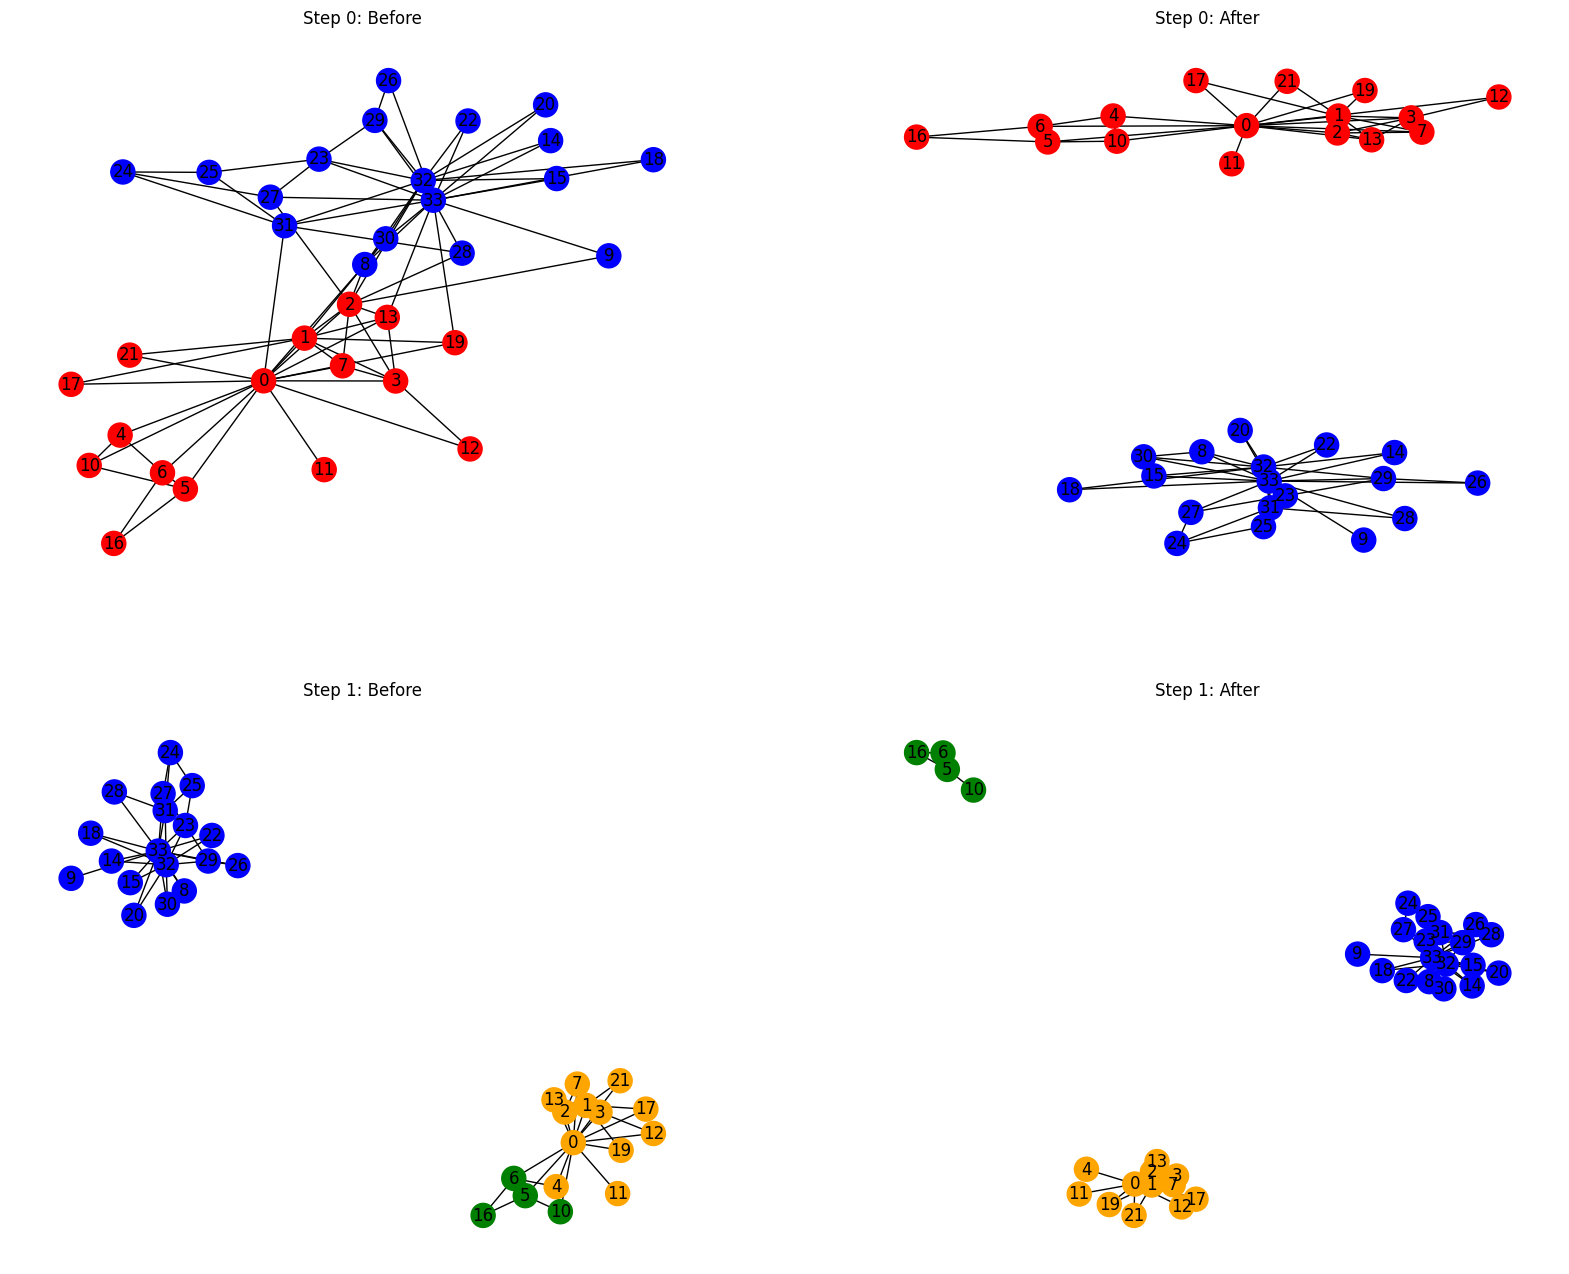

In [10]:
import networkx as nx
import matplotlib.pyplot as mp
import numpy as np

# 1. Setup

colors = ['red', 'blue', 'green', 'orange', 'purple', 'darkgreen', 'lightcoral', 'yellow', 'cyan']
plot_pos = 0

G = nx.karate_club_graph()
draw_G = G.copy()

mod_scores = []
communities = {n: -1 for n in G.nodes()}
node_logs = {n: [(0, "null")] for n in G.nodes()}
node_colors = [0] * G.number_of_nodes()
comm_id = 0

# 2. Helpers (Predefining functions)

def calc_modularity(g):

    """Calculates modularity score using the leading eigenvector method."""

    degrees = np.array(g.degree)
    A = nx.adjacency_matrix(g).toarray()

    k = degrees[:, 1]
    k_col = k[:, np.newaxis]

    k_outer = k_col @ k_col.T
    two_m = np.sum(k)

    P = k_outer / two_m
    B = A - P

    vals, vecs = np.linalg.eigh(B)

    s = vecs[:, np.argmax(vals)]
    s_col = s[:, np.newaxis]

    s_T = s_col.T
    score = (1 / two_m) * float((s_T @ B @ s_col)[0, 0].real)
    mod_scores.append(score)

def find_split(g):

    """Finds the best split for a subgraph and updates community IDs."""

    global comm_id
    nodes = list(g.nodes())

    if not nodes: return

    degrees = np.array(g.degree)
    A = nx.adjacency_matrix(g).toarray()

    k = degrees[:, 1]
    k_col = k[:, np.newaxis]

    k_outer = k_col @ k_col.T
    two_m = np.sum(k)

    if two_m == 0: return

    P = k_outer / two_m
    B = A - P

    vals, vecs = np.linalg.eigh(B)
    s = vecs[:, np.argmax(vals)]

    idx = 0
    for n in nodes:
        if s[idx].real > 0:
            communities[n] = comm_id
        else:
            communities[n] = comm_id + 1
        idx += 1

    comm_id += 2

def get_subgraphs(g):

    """Splits graph 'g' into two based on current community IDs."""

    nodes_a = []
    nodes_b = []

    for n in g.nodes():
        if communities[n] % 2 == 0:
            nodes_a.append(n)
        else:
            nodes_b.append(n)

    sub_a = nx.subgraph(G, nodes_a)
    sub_b = nx.subgraph(G, nodes_b)
    return sub_a, sub_b

def log_step(g, color):

    """Logs the current step and color for nodes in 'g'."""

    for n in g.nodes():
        last = node_logs[n][-1][0]
        node_logs[n].append((last + 1, color))

def is_done(g):

    """Checks if a subgraph cannot be split further (all same community)."""

    if nx.is_empty(g): return True

    comms = [communities[n] for n in g.nodes()]
    return len(set(comms)) == 1

def cut_edges(g_a, g_b):

    """Removes edges between two groups in the drawing graph."""

    for n_a in g_a.nodes():
        for n_b in g_b.nodes():
            if draw_G.has_edge(n_a, n_b):
                draw_G.remove_edge(n_a, n_b)

# 3. Main Algorithm

mp.figure(figsize=(20, 16))

def recursive_split(g):
    if nx.is_empty(g): return

    global plot_pos

    # 1. Identifying split
    find_split(g)
    sub_a, sub_b = get_subgraphs(g)

    # 2. Preparing next step IDs
    find_split(sub_a)
    find_split(sub_b)

    # 3. Log and color
    log_step(sub_a, "blue")
    log_step(sub_b, "red")

    for n in G.nodes():
        if n in sub_a.nodes(): node_colors[n] = colors[plot_pos]
        if n in sub_b.nodes(): node_colors[n] = colors[plot_pos + 1]

    # 4. Plot Before
    mp.subplot(2, 2, plot_pos + 1)
    nx.draw_spring(draw_G, with_labels=True, node_color=node_colors)
    mp.title(f"Step {plot_pos // 2}: Before")

    # 5. Cut and Calculate
    cut_edges(sub_a, sub_b)
    calc_modularity(draw_G)

    # 6. Plot After
    mp.subplot(2, 2, plot_pos + 2)
    nx.draw_spring(draw_G, with_labels=True, node_color=node_colors)
    mp.title(f"Step {plot_pos // 2}: After")

    plot_pos += 2

    # 7. Recurse
    if not nx.is_empty(sub_a) and not is_done(sub_a):
        recursive_split(sub_a)
    if not nx.is_empty(sub_b) and not is_done(sub_b):
        recursive_split(sub_b)

# 4. Execution

calc_modularity(G)
recursive_split(G)

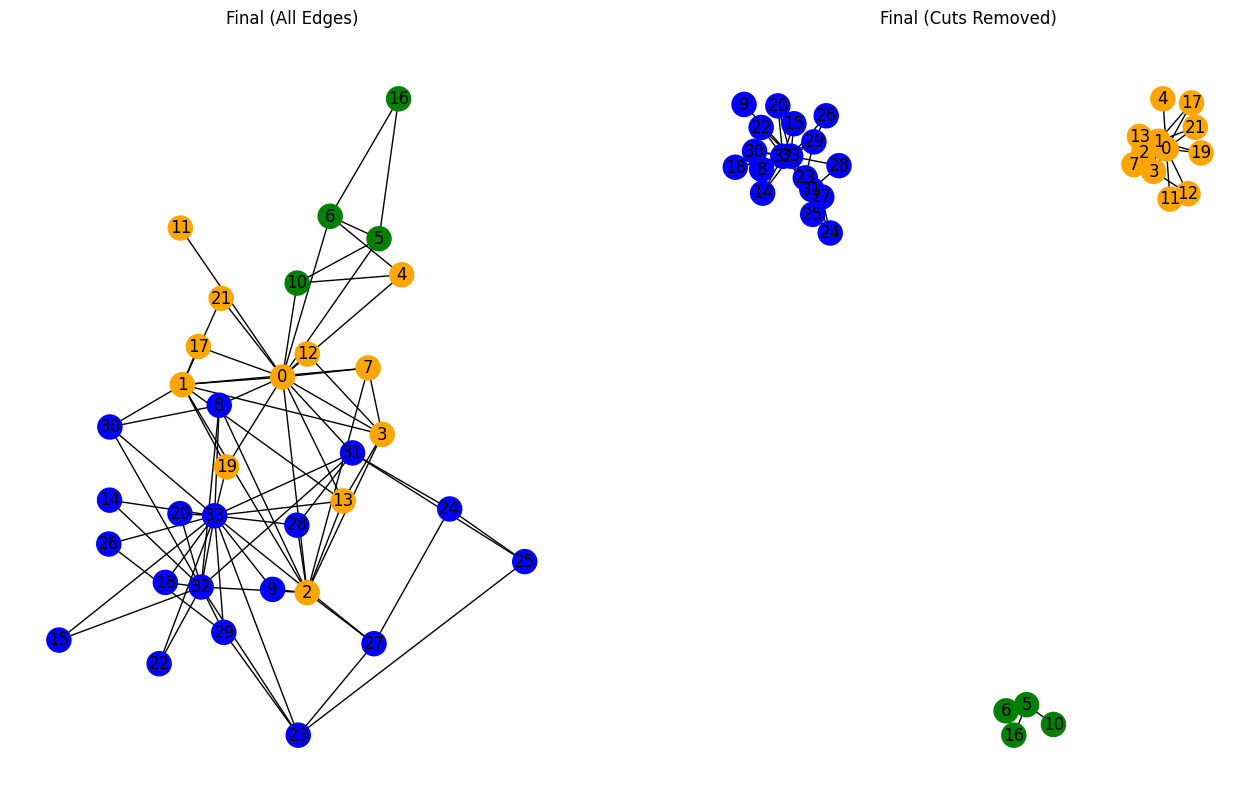

In [11]:
# Cleanup logs
for n in node_logs:
    node_logs[n].pop(0)

max_iters = 0
for n in node_logs:
    if len(node_logs[n]) > max_iters:
        max_iters = len(node_logs[n])

# 5. Metrics Calculation

iter_colors = {i: [] for i in range(1, max_iters + 1)}
hist_deg = {i: {} for i in range(1, max_iters + 1)}
hist_bet = {i: {} for i in range(1, max_iters + 1)}
hist_clo = {i: {} for i in range(1, max_iters + 1)}
hist_clus = {i: {} for i in range(1, max_iters + 1)}

def calc_metrics(logs, limit):
    c_idx = 0
    for i in range(1, limit + 1):
        nodes_r = []
        nodes_b = []

        for n in logs:
            if i <= len(logs[n]):
                entry = logs[n][i-1]
                if entry[1] == "red":
                    nodes_r.append(n)
                    iter_colors[i].append(colors[c_idx])
                else:
                    nodes_b.append(n)
                    iter_colors[i].append(colors[c_idx + 1])

        sa = nx.subgraph(G, nodes_r)
        sb = nx.subgraph(G, nodes_b)

        # Merging metrics from both subgraphs
        deg = nx.degree_centrality(sa) | nx.degree_centrality(sb)
        hist_deg[i] = dict(sorted(deg.items()))

        bet = nx.betweenness_centrality(sa) | nx.betweenness_centrality(sb)
        hist_bet[i] = dict(sorted(bet.items()))

        clo = nx.closeness_centrality(sa) | nx.closeness_centrality(sb)
        hist_clo[i] = dict(sorted(clo.items()))

        clus = nx.clustering(sa) | nx.clustering(sb)
        hist_clus[i] = dict(sorted(clus.items()))

        c_idx += 2

calc_metrics(node_logs, max_iters)

# Carrying forward values for terminal nodes
for n in G.nodes():
    if n not in hist_deg[2]: hist_deg[2][n] = hist_deg[1][n]
    if n not in hist_bet[2]: hist_bet[2][n] = hist_bet[1][n]
    if n not in hist_clo[2]: hist_clo[2][n] = hist_clo[1][n]
    if n not in hist_clus[2]: hist_clus[2][n] = hist_clus[1][n]

# 6. Plotting

# Final Communities
mp.figure(figsize=(16, 10))
mp.subplot(1, 2, 1)
final_G = G.copy()
nx.draw_kamada_kawai(final_G, with_labels=True, node_color=node_colors)
mp.title("Final (All Edges)")

# Removing final cut edges for visual clarity
for e in final_G.edges():
    if communities[e[0]] != communities[e[1]]:
        G.remove_edge(e[0], e[1])

mp.subplot(1, 2, 2)
nx.draw_spring(G, with_labels=True, node_color=node_colors)
mp.title("Final (Cuts Removed)")
mp.show()


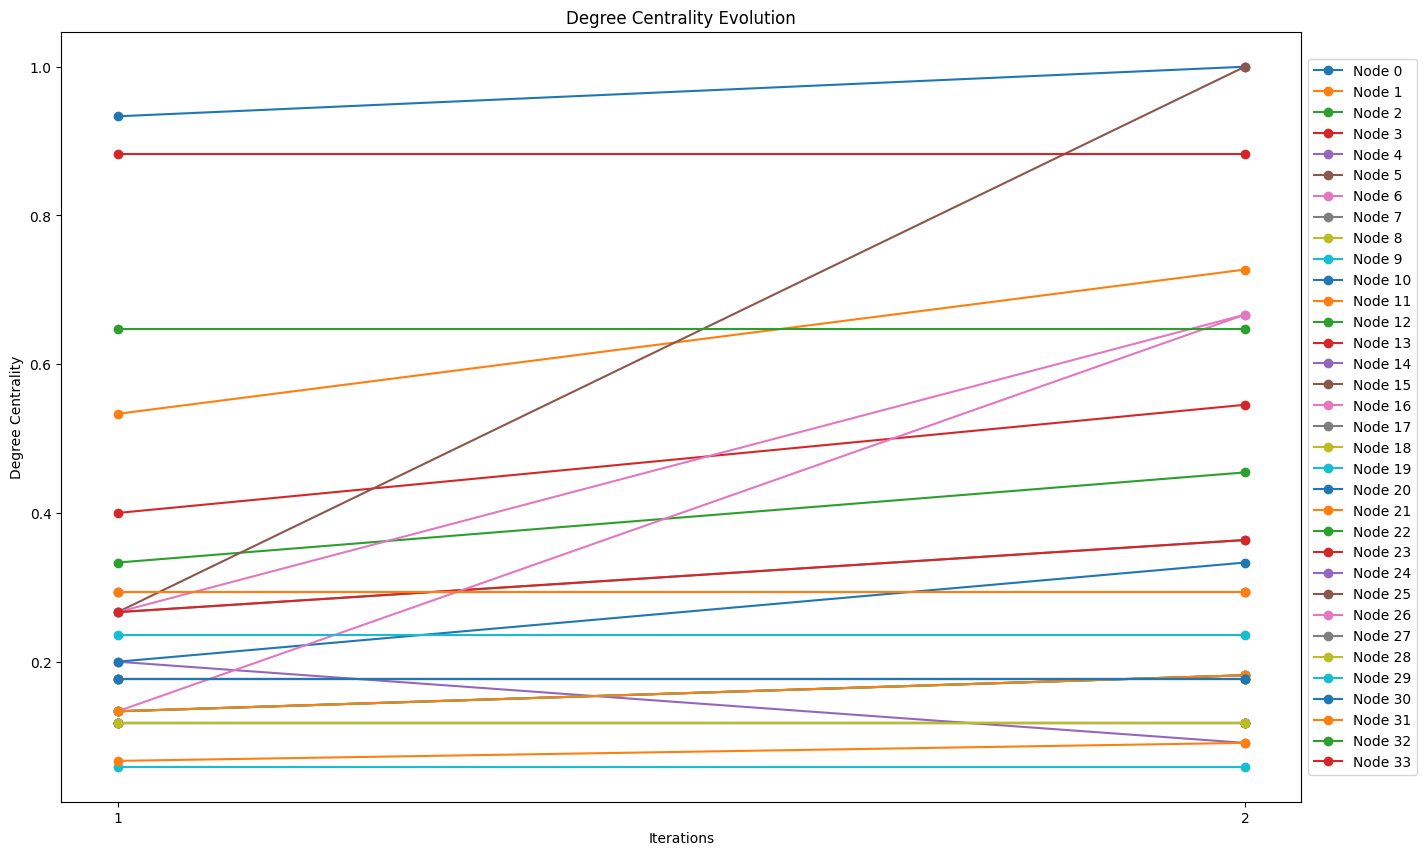

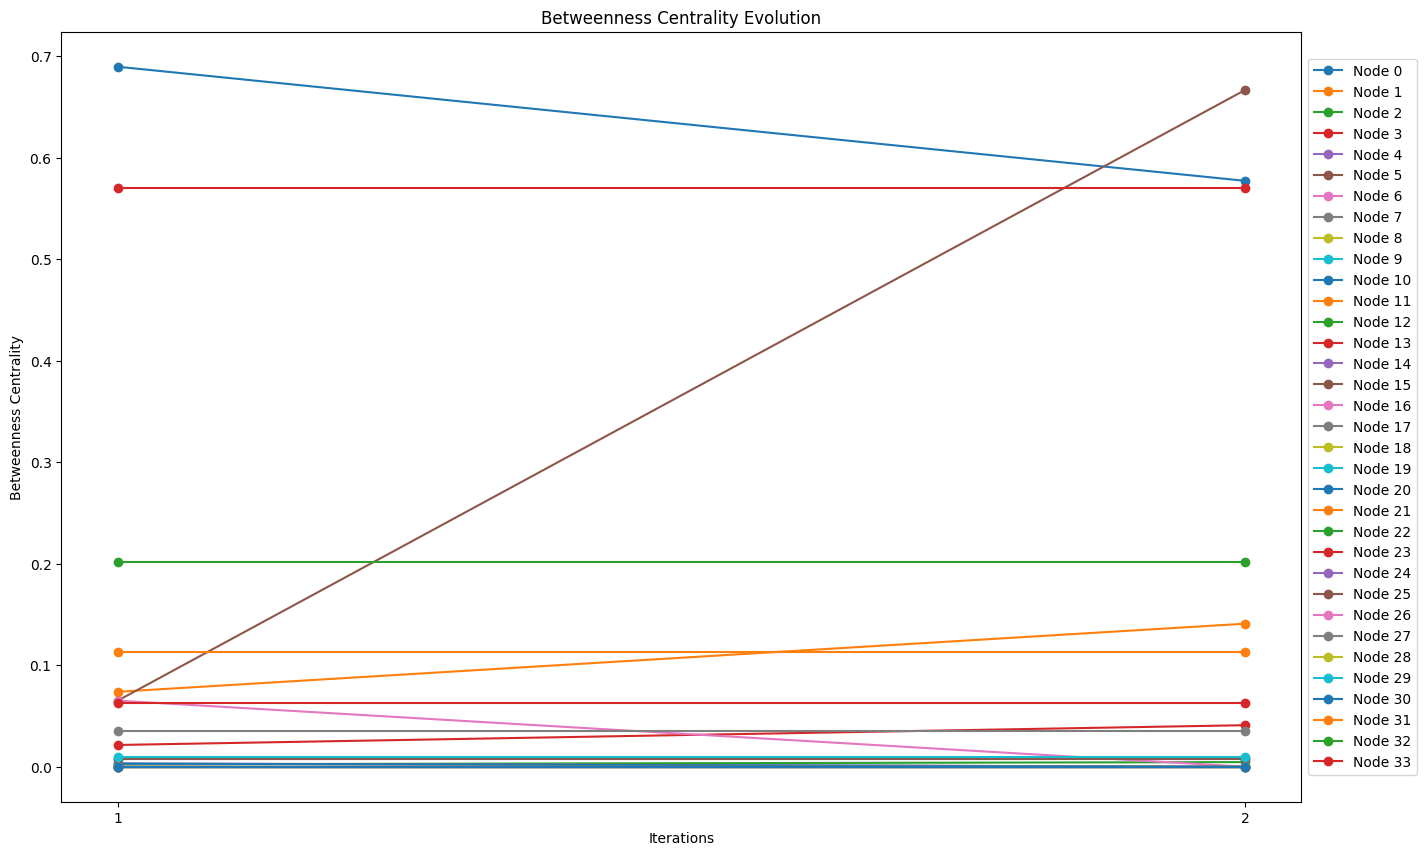

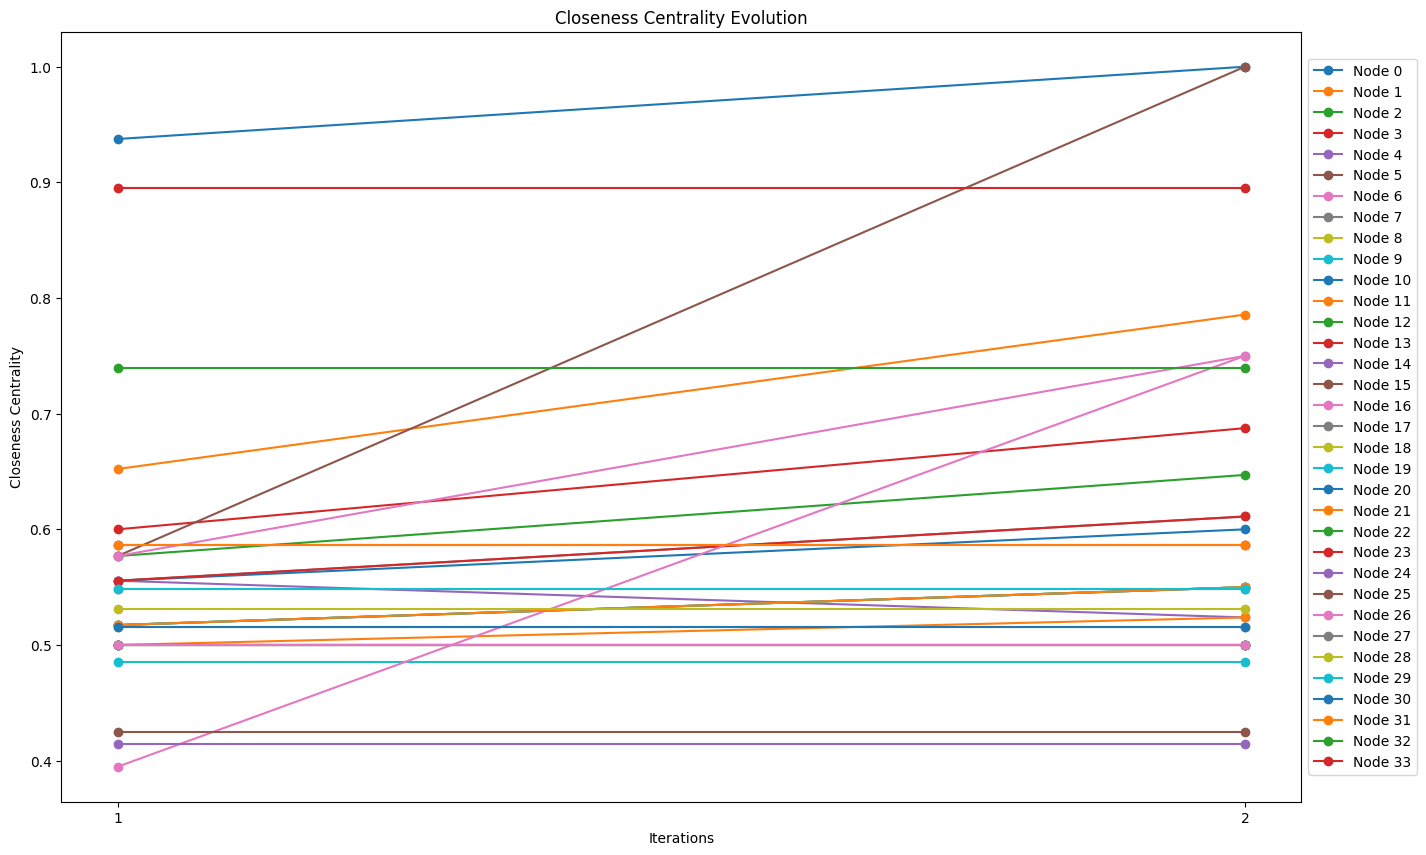

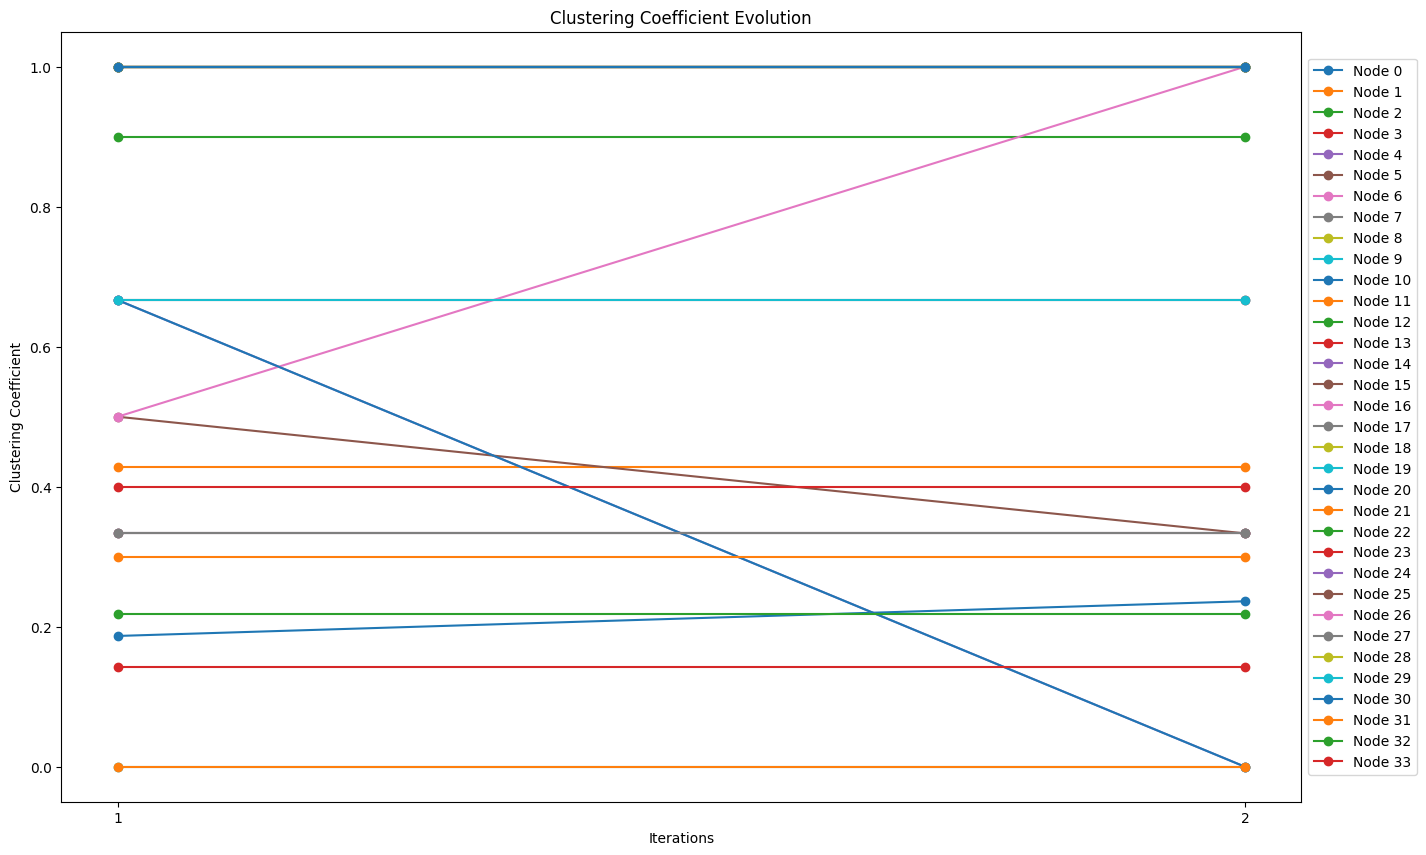

In [12]:
# Metric Evolution Plots
iters = [1, 2]
nodes_sorted = sorted(list(G.nodes()))

def plot_metric(hist1, hist2, name):
    mp.figure(figsize=(16, 10))
    y1 = [hist1[n] for n in nodes_sorted]
    y2 = [hist2[n] for n in nodes_sorted]

    for n in nodes_sorted:
        mp.plot(iters, [y1[n], y2[n]], 'o-', label=f"Node {n}")

    mp.xlabel('Iterations')
    mp.ylabel(name)
    mp.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    mp.title(f'{name} Evolution')
    mp.xticks(iters)
    mp.show()

plot_metric(hist_deg[1], hist_deg[2], 'Degree Centrality')
plot_metric(hist_bet[1], hist_bet[2], 'Betweenness Centrality')
plot_metric(hist_clo[1], hist_clo[2], 'Closeness Centrality')
plot_metric(hist_clus[1], hist_clus[2], 'Clustering Coefficient')

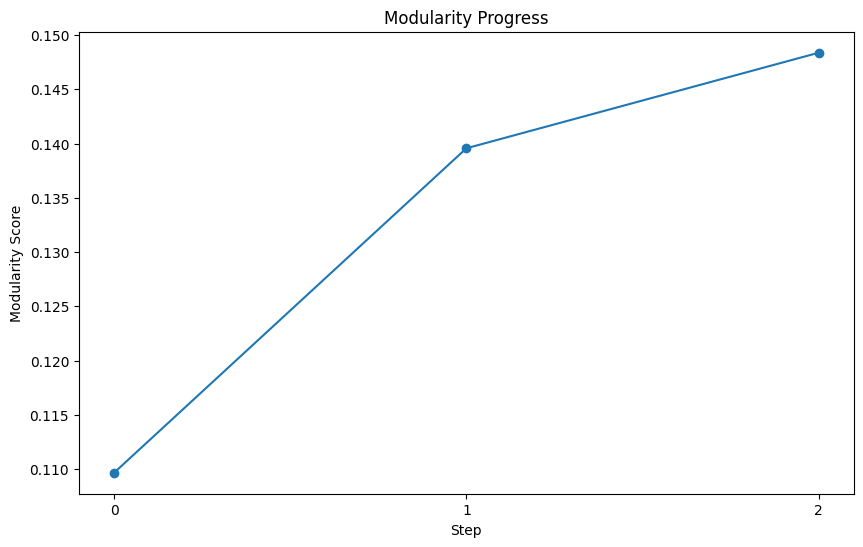

In [13]:
# Modularity Plot
mp.figure(figsize=(10, 6))
steps = list(range(len(mod_scores)))
mp.plot(steps, mod_scores, 'o-')
mp.xlabel('Step')
mp.ylabel('Modularity Score')
mp.title('Modularity Progress')
mp.xticks(steps)
mp.show()

 The modularity steadily increasing with each iteration with the very first iteration yielding the largest increase with subsequent ones leading to diminishing returns.

Degree Centrality:
Notable trends are visible in nodes 0, 5, and 12, which exhibit a sharp increase in degree centrality. Nodes 0 and 5, in particular, reach a value of 1, marking their emergence as leaders of their respective communities. Meanwhile, node 33 maintains a consistently high degree centrality, reinforcing its status as an established, incumbent leader.

Betweenness Centrality:
Betweenness centrality remains largely stable for the majority of nodes, suggesting they retain their original structural roles within their communities. However, nodes 0 and 5 deviate from this pattern; their separation from the initial graph to spearhead new communities results in a significant positive shift in betweenness. This suggests a correlation where sharp increases in betweenness signal the rise of "leaders," while stability characterizes the "followers."

Closeness Centrality:
Closeness centrality highlights the migration of nodes from groups where they were peripheral to those where they hold greater structural significance. Nodes 5, 6, 10, and 16 display a marked increase in this metric, reflecting their transition into communities where they serve as central figures. Node 0 and its neighbors show a similar, though smaller, trend. Conversely, members of the primary community show no significant change, indicating they were already well-integrated core members of their original cluster.

Clustering Coefficient:
The clustering coefficients reveal drastic role reversals. Nodes 8 and 17 (whose trajectories overlap) plummet from 1.0 to 0.0, indicating a shift from being part of a tight-knit cluster to becoming peripheral outliers. In direct contrast, nodes 10 and 11 surge from 0.0 to 1.0, transitioning from outliers to deeply interconnected core members of their new clusters.